In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

sns.set_style('white')

%matplotlib inline

dump_dir = ''
client = pymongo.MongoClient('localhost', 27017)
db = client.gamesdb

In [10]:
db.collection_names()

['turing', 'test_collection']

## AI

In [2]:
C = db.turing
cursor = C.find({'task':'AI'})

output_cols = ['user_name', 'opponent', 'color', 'bp', 'wp', 'response', 'rt', 'ts', 'status']

AI = pd.DataFrame(list(cursor))

In [3]:
print(AI.user_name.unique())
AI.head()

['RR' 'SR' 'JC' 'MJ' 'OM' 'CR' 'AV' 'BB' 'FD' 'adfjk' 'bas' 'AF' 'SD' 'ARS'
 'DT' 'AJ' 'TCK' 'GK' 'TW' 'weiji' 'DX' 'CW' 'AP' 'CS' 'JP' 'AS' 'PC'
 'Ahmed' 'SJ']


,_id,bp,color,gi,initials,mt,mxy,opponent,response,rt,status,task,ts,user_name,wp
0,57fba6489100de0961e9c639,000000000000000000000000000000000000,0,0,1476109832464,,,17,99,0,ready,AI,1476109895631,RR,000000000000000000000000000000000000
1,57fba64e9100de0961e9c63a,000000000000010000000000000000000000,0,0,1476109832464,"1476109898467,1476109898477,1476109898487,1476...","322,304;323,302;326,298;327,294;329,291;329,28...",17,13,4013,playing,AI,1476109901690,RR,000000000000000000000000000000000000
2,57fba6549100de0961e9c63b,000000000000010000000100000000000000,0,0,1476109832464,"1476109901690,1476109905593,1476109905603,1476...","965,333;966,334;968,335;969,336;971,338;974,34...",17,21,2503,playing,AI,1476109907286,RR,000000000000100000000000000000000000
3,57fba65a9100de0961e9c63c,000000000000010000000100000001000000,0,0,1476109832464,"1476109907296,1476109907469,1476109907469,1476...","851,493;853,493;853,494;856,495;858,495;862,49...",17,29,2626,playing,AI,1476109913015,RR,000000000000100000001000000000000000
4,57fba6609100de0961e9c63d,000000000000010000000100000011000000,0,0,1476109832464,"1476109913015,1476109913125,1476109913135,1476...","698,627;699,627;700,627;701,627;703,627;707,62...",17,28,3476,playing,AI,1476109919462,RR,000001000000100000001000000000000000


In [5]:
exclude = ['adfjk', 'bas', 'weiji', 'Ahmed']
AI = AI.loc[~AI.user_name.isin(exclude)].reset_index(drop=True)

In [6]:
AI_out = AI.loc[AI.status != 'ready', output_cols]
AI_out['new_game'] = AI.bp.map(lambda x: int(np.array(list(x)).astype(int).sum()==1))
AI_out['last_move'] = AI_out['new_game'].shift(-1)
AI_out['status_code'] = AI_out.status.map(lambda x: 1 if x=='win' else 0)
AI_out['opponent'] = AI_out['opponent'].astype(int)
AI_out['opponent_bin'] = AI_out['opponent'] // 5
AI_out.to_csv(dump_dir + 'AI.csv')

In [32]:
gl = np.loadtxt('/Users/maadmin/Downloads/game_length.txt') * 1.5
cursor = db.test_collection.find({'task': {'$in': ['turing']}})
T = pd.DataFrame(list(cursor))
exclude = ['bas', 'bvf', 'tes', 'test', 'gianni', 'dsfv', 'yunqi', 'adfjk', 'badsafgdsdg', 'don', 'Weiji', 'adfads', 'admin']
output_cols = ['user_name', 'task', 'clip_id', 'choice', 'feedback', 'timestamp', 'trial_start', 'experiment_start', 'start']
T = T.loc[~T.user_name.isin(exclude), output_cols].reset_index(drop=True)
T['feedback'] = T['feedback'].map(lambda x: 0 if x == 'false' else 1)
T['rt'] = (T['timestamp'].astype(int) - T['timestamp'].astype(int).shift(1))
T['game_length'] = gl[T['clip_id']]
T.to_csv(dump_dir + 'Turing.csv')
T.head()

/Users/maadmin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


,user_name,task,clip_id,choice,feedback,timestamp,trial_start,experiment_start,start,rt,game_length
0,RR,turing,86,65,0,1476191048451,NaN,NaN,1476189968850,NaN,7.5
1,RR,turing,50,63,0,1476191167511,NaN,NaN,1476191108153,119060.0,3.0
2,RR,turing,48,34,0,1476191190372,NaN,NaN,1476191108153,22861.0,10.5
3,RR,turing,35,33,0,1476191217315,NaN,NaN,1476191108153,26943.0,9.0
4,RR,turing,64,38,0,1476191241350,NaN,NaN,1476191108153,24035.0,7.5


## Turing figures

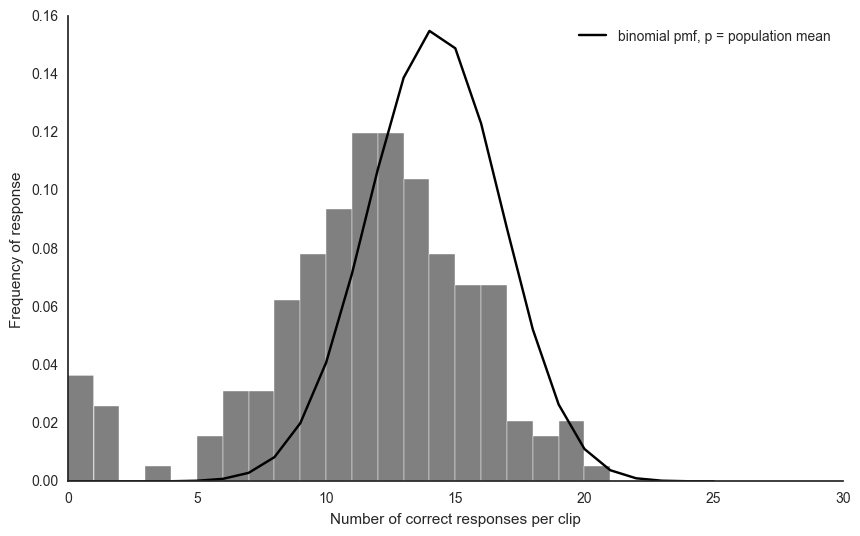

In [58]:
clip_piv = T.pivot_table(index='clip_id', values='feedback', aggfunc=np.sum)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.hist(clip_piv.values, normed=True, color='grey', edgecolor='white', bins=np.arange(0, 27, 1))
x = np.arange(0, 26, 1)
y = sts.binom.pmf(x, T['user_name'].unique().size, T['feedback'].mean())
axes.plot(x, y, color='black', label='binomial pmf, p = population mean')
plt.setp(axes, xlabel='Number of correct responses per clip', ylabel='Frequency of response')
axes.legend()
sns.despine()

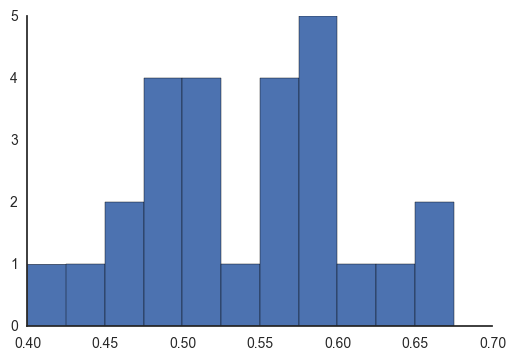

In [72]:
sub_piv = T.pivot_table(index='user_name', values='feedback', aggfunc=np.mean)
plt.hist(sub_piv.values, bins=np.arange(.4, .7, .025))
sns.despine()

In [20]:
fd = T.loc[(T.user_name=='FD'), :]
gl[fd.clip_id.astype(int)]

array([  7.5,   3. ,  12. ,   7.5,  15. ,  12. ,  12. ,  13.5,   4.5,
        30. ,   4.5,  10.5,  16.5,   6. ,  16.5,   4.5,  10.5,  18. ,
         3. ,  19.5,  28.5,  42. ,  15. ,   3. ,   6. ,   7.5,  13.5,
        25.5,  19.5,   3. ,  24. ,  24. ,  15. ,  15. ,   9. ,  22.5,
        24. ,  27. ,   3. ,  22.5,   4.5,  19.5,  24. ,  15. ,   3. ,
        12. ,   1.5,   3. ,  15. ,   7.5,  13.5,  24. ,  10.5,  18. ,
         4.5,   1.5,  24. ,  12. ,  16.5,   9. ,  19.5,   6. ,  10.5,
        31.5,  15. ,  15. ,  19.5,  51. ,  16.5,  12. ,   7.5,   6. ,
         9. ,  10.5,   7.5,  16.5,   4.5,  12. ,  10.5,  15. ,  19.5,
        10.5,  13.5,  22.5,  16.5,  12. ,  10.5,  10.5,   9. ,  21. ,
        13.5,  15. ,   4.5,   1.5,   9. ,  13.5,  12. ,  27. ,  12. ,
        30. ,   3. ,   6. ,  10.5,  10.5,   6. ,   1.5,  15. ,  24. ,
        18. ,  31.5,   9. ,  18. ,   4.5,   4.5,  18. ,   4.5,  15. ,
        37.5,  42. ,  19.5,  15. ,   7.5,  10.5,  27. ])

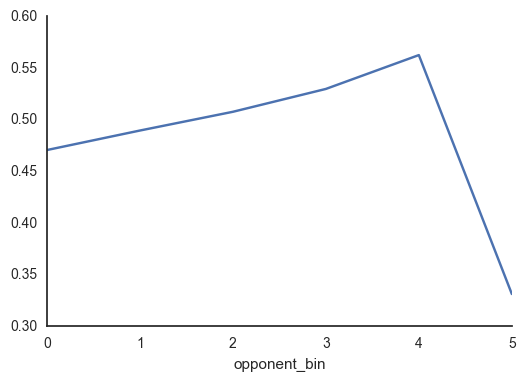

In [4]:
winfrac = AI_out.loc[AI_out.last_move==1, :].pivot_table(
    index='opponent_bin', values='status_code', aggfunc=np.mean
).sort_index()

winfrac.plot()
sns.despine()

# Turing

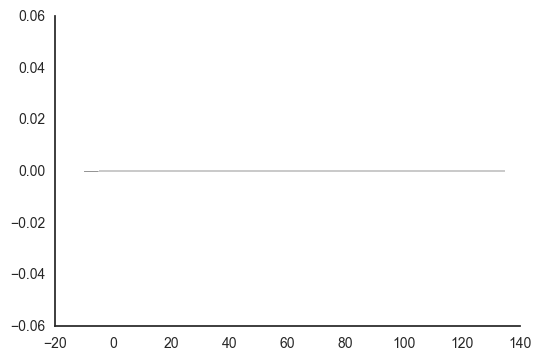

In [8]:
fd['gl'] = gl[fd.clip_id.astype(int)]

plt.hist(fd.rt.values[1:]/1000 - fd.gl.values[1:], bins=np.arange(-10, 140, 5))
sns.despine()

In [9]:
g = turing.loc[turing.user_name.isin(['Weiji']), :] # 'gianni'
g['correct'] = g['feedback'].map(lambda x: x=='true').astype(int)
g['correct'] = g['correct'].astype(int)
sts.bayes_mvs(g.correct, alpha=.95) #.loc[g.user_name=='BB', :]

(Mean(statistic=0.68333333333333335, minmax=(0.61472367213265267, 0.75194299453401403)),
 Variance(statistic=0.22005649717514122, minmax=(0.17871828631541622, 0.27077796608729293)),
 Std_dev(statistic=0.46843969636424665, minmax=(0.42275085607886848, 0.52036330201820813)))

In [5]:
sts.bayes_mvs(g.loc[g.user_name=='FD', 'correct'].values.astype(int))

(Mean(statistic=0.44354838709677419, minmax=(0.36930764278629979, 0.51778913140724858)),
 Variance(statistic=0.25293255131964815, minmax=(0.20418940138459951, 0.31106434740491695)),
 Std_dev(statistic=0.50188598687186847, minmax=(0.45187321383835038, 0.55773142945768883)))

In [6]:
g.loc[g.user_name=='FD', 'choice'].values.astype(int).size

124

LinregressResult(slope=-0.0037701386286998779, intercept=55.311405254777071, rvalue=-0.0047663172843010956, pvalue=0.96323956356561502, stderr=0.081584096915791812)


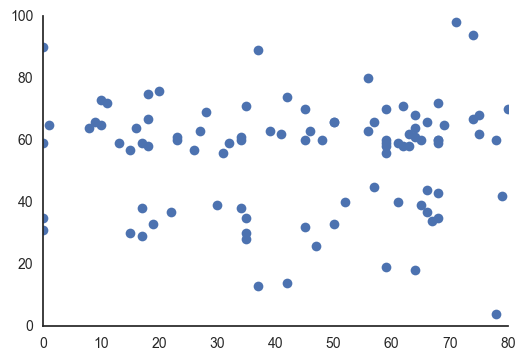

In [41]:
x = g.loc[g.user_name=='BB', 'choice'].values.astype(int)
y = g.loc[g.user_name=='gianni', 'choice'].values.astype(int)
print(sts.linregress(x, y))
plt.plot(
    x, 
    y, 
    linestyle='none', marker='o'
)

sns.despine()

In [10]:
BB = g.loc[g.user_name=='BB', :]
print(sts.linregress(BB.choice.astype(int), BB.correct.astype(int)))

LinregressResult(slope=-0.0017997644917839752, intercept=0.74570632393084624, rvalue=-0.086974910919928705, pvalue=0.39944556658541497, stderr=0.0021262233129241532)


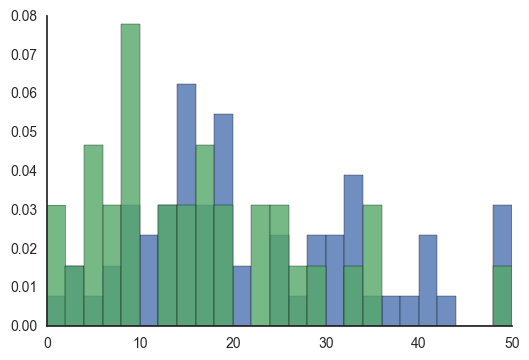

In [29]:
x = np.abs(50-BB.loc[BB.correct==1, 'choice'].values.astype(int))
y = np.abs(50-BB.loc[BB.correct==0, 'choice'].values.astype(int))
plt.hist(np.abs(50-BB.loc[BB.correct==1, 'choice'].values.astype(int)), bins=np.arange(0, 51, 2), alpha=.8, normed=True)
plt.hist(np.abs(50-BB.loc[BB.correct==0, 'choice'].values.astype(int)), bins=np.arange(0, 51, 2), alpha=.8, normed=True)
sns.despine()

In [30]:
sts.bayes_mvs(y)

(Mean(statistic=16.03125, minmax=(12.571276874115487, 19.491223125884513)),
 Variance(statistic=142.44719827586206, minmax=(91.829214779006804, 214.2555463201835)),
 Std_dev(statistic=11.832697957626831, minmax=(9.5827561160141599, 14.637470625766717)))

In [27]:
sts.bayes_mvs(x)

(Mean(statistic=21.921875, minmax=(19.258516522312245, 24.585233477687755)),
 Variance(statistic=168.23949795081967, minmax=(124.35196573453598, 224.36161925181236)),
 Std_dev(statistic=12.917669418094432, minmax=(11.151321255104078, 14.978705526573796)))

## One offs:

(correcting errors)

In [87]:
# EXAMPLE: replace user_name field to be correct

F = {'user_name': }
U = {'$set': {'user_name': 'MJ'}}

C.update(F, U, multi=True)

{'n': 404, 'nModified': 404, 'ok': 1, 'updatedExisting': True}

In [19]:
# EXAMPLE: remove test user from database

F = {'user_name': {'$in': ['gianni', 'bas', 'test']}}

C.remove(F, multi=True)

{'n': 13, 'ok': 1}